# For very LOOOOOOOOOOOOOOOOOOOOOOOOONG byte sequences
basically just make it append to a file lol

In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from scipy.io import wavfile

In [2]:
file_in = "Screenshot 2023-11-12 100037.bmp"
img = Image.open(file_in)

array = np.array(img)
data_shape = array.shape
print(data_shape)

#print(type(array.tobytes()))

data = array.tobytes()
print(array.dtype)

(311, 311, 3)
uint8


In [3]:
cycles = 5000
resolution = 5000 * 4# + 1

# symbols/chunk
chunk_size = 512

bitrate_norm = 256
bitrate_slow = 32

high_bit_amp = 8
low_bit_amp = 1
high_bit_amp_thresh = 2.2
snr_reciprocal = 1.5
symbol_bits = 8
chunk_size = symbol_bits * chunk_size
plot_or_nah = False

In [23]:
def bitinize(string_or_bytes):
  if isinstance(string_or_bytes, str):
    str_codes = "".join([bin(ord(a))[2:].zfill(symbol_bits) for a in string_or_bytes])
  else:
    str_codes = "".join([bin(a)[2:].zfill(symbol_bits) for a in string_or_bytes])
  return [int(a) for a in str_codes]

bin_seq = bitinize(data)

chunk_count = len(bin_seq) // chunk_size + 1
len_secs = chunk_size / symbol_bits // bitrate_norm

# if len_secs < 1:
#   print("USING LOWERED BITRATE")
#   len_secs = len(bin_seq)/8//bitrate_slow

print(len(bin_seq), "BITs msg")
print(chunk_count, "CHUNKs")
print(len_secs, "SECs/CHUNK")
print(len_secs*chunk_count, "SECs TOTAL")

2321304 BITs msg
567 CHUNKs
2.0 SECs/CHUNK
1134.0 SECs TOTAL


In [24]:
leftover_bits_count = int(len(bin_seq) % chunk_size)
leftover_bits_count

2968

In [25]:
leftover_bits = bin_seq[-leftover_bits_count:]
bin_seq = bin_seq[:-leftover_bits_count]

2318336

In [27]:
def divide_chunks(l, n):
    
    # looping till length l
    for i in range(0, len(l), n): 
        yield (l[i:i + n])

In [35]:
chunked_chunks = list(divide_chunks(bin_seq, chunk_size))
chunked_chunks.append(leftover_bits)
len(chunked_chunks)

567

In [5]:
len_secs = len_secs

datapoint_count = int(resolution * len_secs)

length = np.pi * 2 * cycles * len_secs
carrier_wave = np.sin(np.arange(0, length, length / datapoint_count))

In [6]:
if plot_or_nah:
  plt.plot(carrier_wave)
  plt.title("CARRIER")
  plt.show()

In [7]:
# Add noise
noise = np.random.randn(carrier_wave.shape[0]) * snr_reciprocal

if plot_or_nah: 
  plt.plot(noise)
  plt.title("NOISE")
  plt.show()

In [8]:
print(datapoint_count//len(bin_seq))

9


In [9]:
# I appologize for ooga booga code
holded_bin_seq = []

bit_hold_interval = int(datapoint_count//(len(bin_seq)+1))

for i in bin_seq:
    holded_bin_seq.extend([i]*bit_hold_interval)

if len(holded_bin_seq) < datapoint_count:
    holded_bin_seq.extend([0]*int(datapoint_count-len(holded_bin_seq)))

holded_bin_seq = (np.array(holded_bin_seq) * (high_bit_amp-1)) + low_bit_amp
holded_bin_seq.shape

(22660000,)

In [10]:
modulated = carrier_wave * holded_bin_seq
if plot_or_nah:
  plt.plot(modulated)
  plt.title("CLEAN SIGNAL") 
  plt.show()

print(carrier_wave.shape)

(22660000,)


In [11]:
modulated_noisy = carrier_wave * holded_bin_seq + noise

if plot_or_nah:
  plt.plot(modulated_noisy)
  plt.title("NOISY SIGNAL")
  plt.show()

print(modulated_noisy.shape)
# print(np.ones(my_wave.shape))

(22660000,)


In [12]:
peak_pows_noisy = []
for d in range(bit_hold_interval,len(modulated),bit_hold_interval):
    peak_pows_noisy.append(max(np.array(modulated_noisy[d-bit_hold_interval:d]) >= (high_bit_amp-high_bit_amp_thresh)))

peak_pows_noisy = np.array(peak_pows_noisy).astype(int).tolist()
if plot_or_nah: 
    plt.plot(peak_pows_noisy)
    plt.show()

In [13]:
peak_pows = []
for d in range(bit_hold_interval,len(modulated),bit_hold_interval):
    peak_pows.append(max(np.array(modulated[d-bit_hold_interval:d]) >= (high_bit_amp-high_bit_amp_thresh)))

peak_pows = np.array(peak_pows).astype(int).tolist()
if plot_or_nah:
    plt.plot(peak_pows)
    plt.show()
print("CLEAN-NOISY ERR", (len(peak_pows)-sum(np.array(peak_pows) == np.array(peak_pows_noisy))), "BITs", "FROM",len(np.array(peak_pows)), "BITs")

CLEAN-NOISY ERR 6552 BITs FROM 2517777 BITs


In [14]:
def decode_string(peak_pows_vals):
    # How many elements each
    # list should have
    n = symbol_bits

    recovered_bin_seq = list(divide_chunks(peak_pows_vals, n))
    # BRACE FOR DISGUSTING DOUBLE LIST COMP
    # Actually not so bad
    recovered_bin_seq = [int("".join([str(b) for b in a]),2) for a in recovered_bin_seq]

    # # TODO: This is error prone, please refactor
    recovered_char_seq = []
    for b in recovered_bin_seq:
        try:
            recovered_char_seq+=chr(b)
        except:
            recovered_char_seq+="??"
    data_str = "".join(recovered_char_seq).split("/")
    data_str_len = len(data_str[0])+2
    try:
        idx = int(data_str[0][4:])+data_str_len
    except:
        idx = 0
    return bytes(recovered_bin_seq), idx, data_str_len

In [15]:
recovered_data, data_idx_start, data_str_len = decode_string(peak_pows)
recovered_data = recovered_data[data_str_len:data_idx_start]
recovered_array = np.frombuffer(recovered_data,dtype=np.uint8).reshape(data_shape)

recovered_data_noisy = decode_string(peak_pows_noisy)[0]
recovered_data_noisy = recovered_data_noisy[data_str_len:data_idx_start]
recovered_array_noisy = np.frombuffer(recovered_data_noisy,dtype=np.uint8).reshape(data_shape)

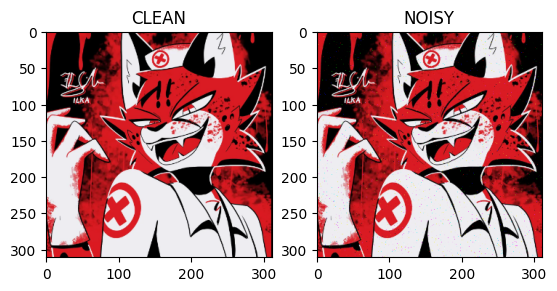

(311, 311, 3)


In [16]:
plt.subplot(1,2,1)
plt.title("CLEAN")
plt.imshow(recovered_array)

plt.subplot(1,2,2)
plt.title("NOISY")
plt.imshow(recovered_array_noisy)
plt.savefig(file_in.split(".")[0]+".comp.png")
plt.show()

plt.imsave(file_in.split(".")[0]+".clean.png", recovered_array)
plt.imsave(file_in.split(".")[0]+".noisy.png", recovered_array_noisy)

print(data_shape)

In [17]:
print(chr(int(bin(ord("💗")),2)))
print(bin(ord("a")))
print("a".encode("utf-16"))

💗
0b1100001
b'\xff\xfea\x00'


In [18]:
from scipy.interpolate import interp1d
m = interp1d([min(modulated_noisy),max(modulated_noisy)],[0,255])

In [19]:
wavfile.write("modulated_clean.wav", resolution, m(modulated).astype(np.uint8))
wavfile.write("modulated_noisy.wav", resolution, m(modulated_noisy).astype(np.uint8))
wavfile.write("carrier.wav", resolution, m(carrier_wave).astype(np.uint8))
wavfile.write("noise.wav", resolution, m(noise).astype(np.uint8))

In [20]:
print(plt.subplot.__doc__)

Add an Axes to the current figure or retrieve an existing Axes.

This is a wrapper of `.Figure.add_subplot` which provides additional
behavior when working with the implicit API (see the notes section).

Call signatures::

   subplot(nrows, ncols, index, **kwargs)
   subplot(pos, **kwargs)
   subplot(**kwargs)
   subplot(ax)

Parameters
----------
*args : int, (int, int, *index*), or `.SubplotSpec`, default: (1, 1, 1)
    The position of the subplot described by one of

    - Three integers (*nrows*, *ncols*, *index*). The subplot will take the
      *index* position on a grid with *nrows* rows and *ncols* columns.
      *index* starts at 1 in the upper left corner and increases to the
      right. *index* can also be a two-tuple specifying the (*first*,
      *last*) indices (1-based, and including *last*) of the subplot, e.g.,
      ``fig.add_subplot(3, 1, (1, 2))`` makes a subplot that spans the
      upper 2/3 of the figure.
    - A 3-digit integer. The digits are interpreted as if